# Estimate commute emissions


## Setup

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
seed = 42
random.seed(seed)

In [4]:
def sample_approximate_distances(employees, mode_share, lower_limit, upper_limit, distance_share):
    
    approximate_distances = [random.randint(lower_limit, upper_limit) for i in range(int(round(round(employees * mode_share, 0) * distance_share, 0)))]
    
    return approximate_distances

## Inputs

In [5]:
year = 2022
employees = 500
car_share = 0.35
public_transport_share = 0.40
average_weekly_office_days = 3
foot_bike_share = 1 - car_share - public_transport_share

In [6]:
print(f'foot/bike share: {foot_bike_share:.0%}')
print(f'public transport share: {public_transport_share:.0%}')
print(f'car share: {car_share:.0%}')
print(f'total: {(foot_bike_share + public_transport_share + car_share):.0%}')

foot/bike share: 25%
public transport share: 40%
car share: 35%
total: 100%


## Oneway distances

In [7]:
# same property (0.5%) is added to below 5 km
# changing work place (1.4%) is added to 25 up to 50 km
# these choices are somewhat arbitrary but need to be made in order for the shares to sum up to 1
# all commute modes are included in the respective shares
# it seems sensible to assume that public transport commute distances are genereally lower than car commute distances
# this leads to public transport commute distances being rather too high
# and car commute distances being rather too low

### Foot/bike

In [8]:
foot_bike_df = pd.DataFrame()
foot_bike_df['mode'] = ['foot/bike'] * int(round(employees * foot_bike_share, 0))
foot_bike_df['oneway_distance'] = 0 # distance doesn't matter here because emissions are 0 anyway
foot_bike_df.shape

(125, 2)

### Public transport

In [9]:
random.seed(seed)

below_5_km = sample_approximate_distances(employees, public_transport_share, 1, 5, 0.258 + 0.005)
from_5_up_to_10_km = sample_approximate_distances(employees, public_transport_share, 5, 10, 0.223)
from_10_up_to_25_km = sample_approximate_distances(employees, public_transport_share, 10, 25, 0.302)
from_25_up_to_50_km = sample_approximate_distances(employees, public_transport_share, 25, 50, 0.148 + 0.014)
from_50_up_to_100_km = sample_approximate_distances(employees, public_transport_share, 50, 100, 0.051)

public_transport_distances = below_5_km + from_5_up_to_10_km + from_10_up_to_25_km + from_25_up_to_50_km + from_50_up_to_100_km
len(public_transport_distances)

200

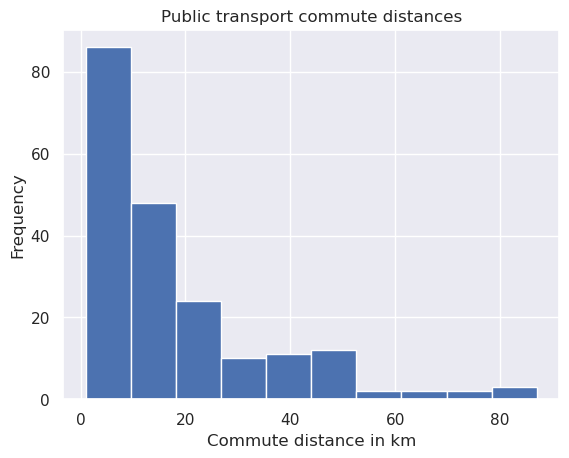

In [10]:
plt.hist(public_transport_distances)
plt.title('Public transport commute distances')
plt.ylabel('Frequency')
plt.xlabel('Commute distance in km')
plt.show()

In [11]:
public_transport_df = pd.DataFrame()
public_transport_df['mode'] = ['public_transport'] * int(round(employees * public_transport_share, 0))
public_transport_df['oneway_distance'] = public_transport_distances
public_transport_df.shape

(200, 2)

### Car

In [12]:
random.seed(seed)

below_5_km = sample_approximate_distances(employees, car_share, 3, 5, 0.258) # setting lower limit to 3 seems reasonable for this car commute distance group
from_5_up_to_10_km = sample_approximate_distances(employees, car_share, 5, 10, 0.223 + 0.005)
from_10_up_to_25_km = sample_approximate_distances(employees, car_share, 10, 25, 0.302)
from_25_up_to_50_km = sample_approximate_distances(employees, car_share, 25, 50, 0.148 + 0.014)
from_50_up_to_100_km = sample_approximate_distances(employees, car_share, 50, 100, 0.051)

car_distances = below_5_km + from_5_up_to_10_km + from_10_up_to_25_km + from_25_up_to_50_km + from_50_up_to_100_km
len(car_distances)

175

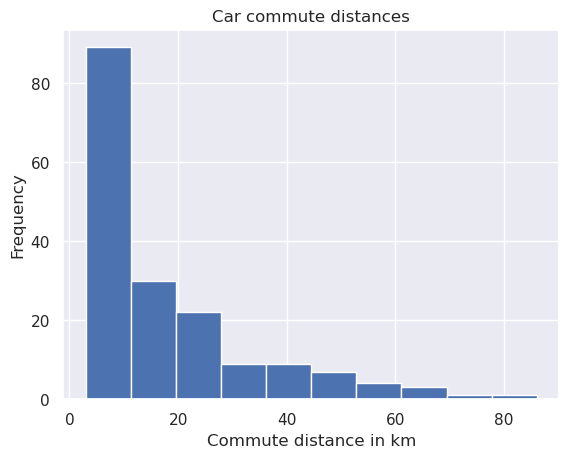

In [13]:
plt.hist(car_distances)
plt.title('Car commute distances')
plt.ylabel('Frequency')
plt.xlabel('Commute distance in km')
plt.show()

In [14]:
car_df = pd.DataFrame()
car_df['mode'] = ['car'] * int(round(employees * car_share, 0))
car_df['oneway_distance'] = car_distances
car_df.shape

(175, 2)

In [15]:
all_modes_df = pd.concat([foot_bike_df, public_transport_df, car_df], ignore_index=True)
all_modes_df

,mode,oneway_distance
0,foot/bike,0
1,foot/bike,0
2,foot/bike,0
3,foot/bike,0
4,foot/bike,0
...,...,...
495,car,53
496,car,65
497,car,86
498,car,55


## Yearly distance

In [16]:
# oneway distance times 2 times average weekly office days times (52 weeks per year - 6 weeks of vacation per year)
all_modes_df['yearly_distance'] = all_modes_df['oneway_distance'] * 2 * average_weekly_office_days * (52 - 6)

## Emission factors

In [17]:
# petrol and diesel (small, medium, large) included
# LNG, CNG and electro excluded for now because their relative share is rather small in comparison
car_emission_factors = [0.2588,
                        0.1757,
                        0.207,
                        0.21952,
                        0.14338,
                        0.18381]

average_car_emission_factor = round(np.mean(car_emission_factors), 5)
average_car_emission_factor

0.19804

In [18]:
# bus, tram/subway, short-distance train (diesel and electro) and long-distance train (diesel and electro) included
public_transport_average_emission_factor = [0.04326,
                                            0.11741,
                                            0.04391,
                                            0.07104,
                                            0.00954,
                                            0.05478]

average_public_transport_emission_factor = round(np.mean(public_transport_average_emission_factor), 5)
average_public_transport_emission_factor

0.05666

In [19]:
mapping_emission_factors = {'foot/bike': 0,
                            'public_transport': average_public_transport_emission_factor,
                            'car': average_car_emission_factor}

In [20]:
all_modes_df['emission_factor'] = all_modes_df['mode'].map(mapping_emission_factors)
all_modes_df

,mode,oneway_distance,yearly_distance,emission_factor
0,foot/bike,0,0,0.00000
1,foot/bike,0,0,0.00000
2,foot/bike,0,0,0.00000
3,foot/bike,0,0,0.00000
4,foot/bike,0,0,0.00000
...,...,...,...,...
495,car,53,14628,0.19804
496,car,65,17940,0.19804
497,car,86,23736,0.19804
498,car,55,15180,0.19804


## Yearly emitted tonnes of CO2 equivalents

In [21]:
all_modes_df['yearly_emissions'] = round((all_modes_df['yearly_distance'] * all_modes_df['emission_factor']) / 1000, 2)
all_modes_df

,mode,oneway_distance,yearly_distance,emission_factor,yearly_emissions
0,foot/bike,0,0,0.00000,0.00
1,foot/bike,0,0,0.00000,0.00
2,foot/bike,0,0,0.00000,0.00
3,foot/bike,0,0,0.00000,0.00
4,foot/bike,0,0,0.00000,0.00
...,...,...,...,...,...
495,car,53,14628,0.19804,2.90
496,car,65,17940,0.19804,3.55
497,car,86,23736,0.19804,4.70
498,car,55,15180,0.19804,3.01


## Emissions overview

In [22]:
total_emissions = round(all_modes_df['yearly_emissions'].sum(), 2)
emissions_per_employee = round(total_emissions / employees, 2)
print(f'Emissions - {year}')
print(f'- total: {total_emissions} t CO2e')
print(f'- per employee: {emissions_per_employee} t CO2e')

Emissions - 2022
- total: 220.72 t CO2e
- per employee: 0.44 t CO2e


## Emissions by mode

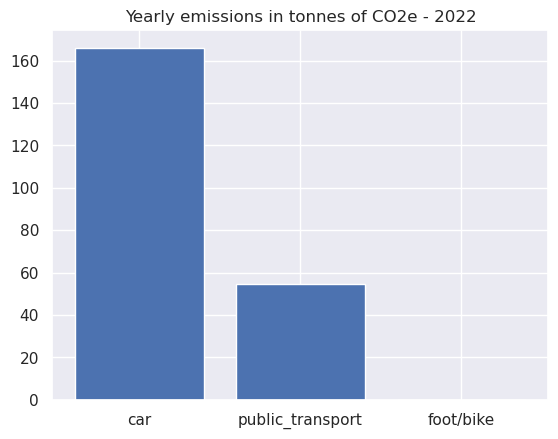

In [23]:
all_modes_df_agg = all_modes_df.groupby('mode').agg({'yearly_emissions': 'sum'}).sort_values('yearly_emissions', ascending=False).reset_index()
plt.bar(all_modes_df_agg['mode'], all_modes_df_agg['yearly_emissions'])
plt.title(f'Yearly emissions in tonnes of CO2e - {year}')
plt.show()

## Relationship between modes and emissions

In [24]:
mapping_modes = {'foot/bike': foot_bike_share,
                 'public_transport': public_transport_share,
                 'car': car_share}

In [25]:
all_modes_df_agg['mode_share'] = all_modes_df_agg['mode'].map(mapping_modes)
all_modes_df_agg

,mode,yearly_emissions,mode_share
0,car,166.18,0.35
1,public_transport,54.54,0.40
2,foot/bike,0.00,0.25


In [26]:
all_modes_df_agg['emission_share'] = round(all_modes_df_agg['yearly_emissions'] / all_modes_df_agg['yearly_emissions'].sum(), 2)
all_modes_df_agg

,mode,yearly_emissions,mode_share,emission_share
0,car,166.18,0.35,0.75
1,public_transport,54.54,0.40,0.25
2,foot/bike,0.00,0.25,0.00


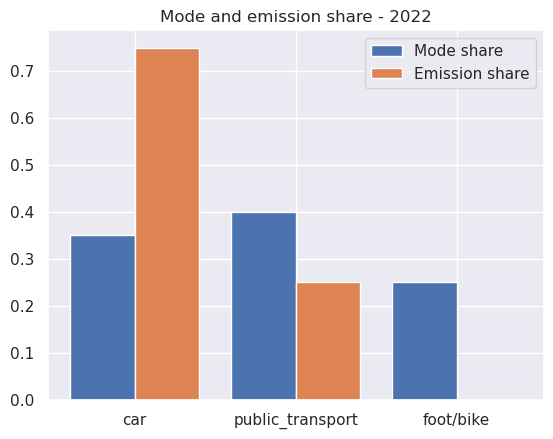

In [27]:
x_axis = np.arange(len(all_modes_df_agg['mode']))
plt.bar(x_axis - 0.2, all_modes_df_agg['mode_share'], 0.4, label = 'Mode share')
plt.bar(x_axis + 0.2, all_modes_df_agg['emission_share'], 0.4, label = 'Emission share')
plt.xticks(x_axis, all_modes_df_agg['mode'])
plt.title(f'Mode and emission share - {year}')
plt.legend()
plt.show()